In [1]:
import nxsdk.api.n2a as nx
import numpy as np
from nxsdk.utils.plotutils import plotRaster
import matplotlib.pyplot as plt

#import our trace injection class
from nxsdk_modules.trace_injection.src.spike_trace_injection import SpikeTraceInjection

# Spike Trace Injection

The previous (Direct Trace Injection) tutorial shows how the trace values of compartments can be externally overwritten to provide a synapse learning rule access to non-local information. The approach has two significant drawbacks.
1. All postsynaptic trace values computed by a compartment are overwritten. In other words, access to non-local (injected) information comes at the cost of access to postsynaptic information.
2. Modifying a large number of trace values is slow because it requires many register writes by a snip.

This tutorial shows a different method of providing access to non-local information through the use of auxiliary compartments. Spikes can be routed to these compartments to control their trace values, and efficient rewiring of synapses by a snip can provide synapses with access to these traces using very few register writes (1 write per core to rewire all connections and followed later by another write to restore the original connections).

## Overview

The spikeTraceInjection class sets up a list of **N** compartmentGroups and a corresponding list of __N__ connectionPrototypes to be used when connecting to the corresponding compartmentGroup. Thus far use of only a single core is supported.

### The user must specify:

* Trace and learning parameters for the core (parameters for X1, X2, Y1, Y2, Y3, and tEpoch are common across the core).
* How many neurons to put in each compartmentGroup (**compartmentsPerGroup**). All compartmentGroups are of equal size.
* A list of **N** compartmentPrototypes specifying the behaviour of each compartmentGroup.
* A list of **N** learning rules to be associated with corresponding compartmentGroups. Whenever a synapse is connected to a compartmentGroup, the learning rule of that compartmentGroup will be applied. *Important: The learning rule is associated with the compartmentGroup, not the connection!*
* An __enableLearning__ list specifying which connections must have learning enabled. This can prevent learning on connections which are only intended for inject spikes into compartments for the sake of influencing their postsynaptic trace.
* A __connectionOrder__ list specifying how to perform synapse offset rewiring during each learning phase. Explained further below

### Wiring
The image below shows a typical configuration.<br>

![Spike Trace Injection_Class](figures/jupyter_spike_trace_injection_class.png)

The __connectionOrder__ list only affects wiring of synapses with learning enabled, and only during the learning phase. <br>
The __enableLearning__ list specifies which synapses have learning enabled (in this case only synapses using $connProto[0]$, which is use to make connections to compartment group 0).

During the learning phase at $t=tEpoch$, the offset is 0, so no rewiring is done. $learningRule[0]$ will be executed. <br>
During the learning phase at $t=2*tEpoch$, an offset of 1 is applied. Synapses to compartments in compartment group 0 will now connect to corresponding compartments in compartment group (0+1=1). $learningRule[1]$ is evaluated using the postsynaptic traces from $cx[1]$<br>
During the learning phase at $t=3*tEpoch$ an offset of N is applied. $learningRule[N]$ is evaluated using the postsynaptic traces from $cx[N]$<br>
During the learning phase at $t=4*tEpoch$, __connectionOrder__ wraps around and an offset of 0 is used again.


## This tutorial

We will use **N**=3 compartment groups. One primary group (group 0) and two auxiliary compartment groups to encode negative and positive components of error (groups 1 and 2 respectively). Note that traces cannot be negative, so we either need to use an offset in our learning rule (see the Direct Trace Injection tutorial) or we need to encode negative and positive error in separate compartments.

Only connections to the primary compartment group will learn. For the auxiliary compartments we want a postsynaptic spike to be induced by every presynaptic spike, so we disable learning on those synapses (to prevent weights becoming zero or inhibitory).

We'll alternate between connecting to the negative and positive error compartment on each learning iteration.

Below is how we'll use the class:
![Spike Trace Injection_Tutorial](figures/jupyter_spike_trace_injection_tutorial.png)

In a real world application, this network would just be one part of a larger network. The spike output of the network could be fed into the positive error compartment, and precomputed spikes representing a target spike output would be fed into the negative error compartment. The error signal seen by the synapses is then 
~~~~
error = (+tve error) - (-tve error) = (output-target)
~~~~

### The steps in this tutorial are:
1. Setup all parameters common to the core (Traces and tEpoch)
2. Create a list of **N** compartmentPrototypes, one for each eventual compartment group.
3. Create a list of **N** learning rules defining the behaviour when synapses are connected to the corresponding compartment group, and the order in which the connections must be made, __connectionOrder__
4. Create an instance of the spikeTraceInjection class passing it the configuration parameters from steps 1, 2, and 3. The class will return a list of compartment groups and a list of connection prototypes to use when connecting to the compartment groups. 
5. Create your network. Weights and delays of connection prototypes can be overridden when creating connections. 
6. Compile the network as usual
7. Call the "setupSnips" function of the spikeTraceInjection instance to prepare the snips for execution
8. Start the board driver as usual
9. Call the "sendSnipInitialization" function of the spikeTraceInjection instance to send the initialization data to the snip
10. Run the board as usual

## 1. Setup Core Parameters

These parameters are shared across all synapses and compartments within the core 

In [2]:
# How often will learning execute? Note that positive and negative components of error 
# will each be evaluated only every 2nd epoch
tEpoch = 2

# Define the presynaptic and postsynaptic trace parameters for the core
x1Impulse=10      
x1TimeConstant=32 
y1Impulse=10      
y1TimeConstant=16 

## 2. Setup a list of CompartmentProtoypes

The number of compartmentGroups, **N**, does not need to be explicitly stated, it will be inferred from the length of the compartment prototype list.

The 1st compartmentPrototype will have a normal integrate and fire behaviour. 

The 2nd and 3rd compartmentPrototypes will spike in response to every input spike they receive. 

In [3]:
# create a list of N compartment prototypes which describe the behaviour of each compartment group
learnCompartmentProto = nx.CompartmentPrototype(vThMant=1000,
                                                compartmentCurrentDecay=int(1/5*2**12),
                                                compartmentVoltageDecay=int(1/10*2**12)
                                               )

errorCompartmentProto = nx.CompartmentPrototype(vThMant=1,
                                                compartmentCurrentDecay=4095,
                                                compartmentVoltageDecay=4095,
                                                enableSpikeBackprop=1,     #enable postsynaptic traces for these compartments
                                                enableSpikeBackpropFromSelf=1 #enable postsynaptic traces for these compartments
                                               )

# this is the list we'll use with spikeTraceInjection
compartmentProtoList = [learnCompartmentProto,
                        errorCompartmentProto,
                        errorCompartmentProto]

## 3. Define learning rules and connectionOrder

The primary compartment group is group 0 <br>
The negative error compartment group is group 1 <br>
The positive error compartment group is group 2 <br>

We will connect first to the negative compartment group, then the positive compartment group, and repeat.

In [4]:
connectionOrderList = [1,2]

Learning should be disabled on the error injection connections

In [5]:
enableLearningList = [1,
                  0,
                  0]

### Learning Rule Considerations

Suppose we want a pseudo learning rule where the change in synaptic weight directly depends on the error. For example
~~~
dw = -e
e = (+tve_error) - (-tve_error)
~~~

The obvious way to approximate this is to have the y1 traces of the positive and negative compartments represent the positive and negative errors respectively, and to write a list of rules:

~~~
dwList = [None,   #never used because our connectionOrder list does not contain 0
          '+u0*y1',    #negative error compartment
          '-u0*y1']    #positive error compartment
~~~

If our positive and negative error components are both large then we'll see large updates to w on each learning iteration, even if (+tve_error) = (-tve_error) so our overall error is zero (try it below!).

We can be smarter by storing our negative error update in the synaptic tag and applying it to the weight during the positive error update.

~~~
dtList = [None,     #never used
          '+u0*y1-u0*t', #negative error compartment has the effect t=u0*y1
          None]   #positive error compartment

dwList = [None,       #never used
          None,       #negative error compartment, dw=0
          '-u0*y1+u0*t'] #positive error compartment
~~~

Now positive and negative errors can cancel out before affecting the weight. We will use a similar rule update in this example, but incorporating x1 to show that presynaptic traces can also be used.

Another consideration concerns timing. The positive error update is evaluated tEpoch later than the negative error update. Adding a delay of tEpoch to the positive error injecting synapses can help synchronize the update.

Presynaptic traces (X1 and X2) cannot be similarly delayed because they are shared by both updates, so any delay applied will affect both updates.

In [6]:
dwList=[None,
        None,
        '2^-2*u0*x1 - u0*y1 + u0*t']

dtList=[None,
        '2^-2*u0*x1 + u0*y1 - u0*t',
        None]

#The parameters below will cause oscillation
dwListOsc=[None,
           '+u0*y1',
           '-u0*y1']

## 4. Create an instance of SpikeTraceInjection

We will add two synapse rewiring cores to SpikeTraceInject. One with the oscillatory learning rule, and one with the non-oscillatory learning rule.

In [7]:
# How many neurons do we want per group
# For each neuron we'll setup 2 auxiliary compartments to inject positive and negative errors, so N=3
# Our total number of compartments will be 3*compartmentsPerGroup and we must ensure this fits on one core
# compartmentsPerGroup < 1024/N 
compartmentsPerGroup = 5

# now actually do the construction
net = nx.NxNet()

sti = SpikeTraceInjection(net=net)

cxList, connProtoList = sti.addRewiringCore(compartmentProtoList=compartmentProtoList, #prototypes for the compartments 
                                  compartmentsPerGroup=compartmentsPerGroup, #number of neurons of each type
                                  connectionOrderList=connectionOrderList, #order in which connections will be made
                                  dwList=dwList,
                                  dtList=dtList,
                                  enableLearningList=enableLearningList,
                                  x1Impulse=x1Impulse,
                                  x1TimeConstant=x1TimeConstant,
                                  y1Impulse=y1Impulse,
                                  y1TimeConstant=y1TimeConstant,
                                  tEpoch=tEpoch)

cxListOsc, connProtoListOsc = sti.addRewiringCore(compartmentProtoList=compartmentProtoList, #prototypes for the compartments 
                                  compartmentsPerGroup=compartmentsPerGroup, #number of neurons of each type
                                  connectionOrderList=connectionOrderList, #order in which connections will be made
                                  dwList=dwListOsc,
                                  enableLearningList=enableLearningList,
                                  x1Impulse=x1Impulse,
                                  x1TimeConstant=x1TimeConstant,
                                  y1Impulse=y1Impulse,
                                  y1TimeConstant=y1TimeConstant,
                                  tEpoch=tEpoch)

## 5. Create the network

We can now create a network using the compartmentGroup list and corresponding connectionPrototype list from the spikeTraceInjection instance.

Compartment group **n**:
~~~
cxList[n]
~~~

Connection prototype **n**:
~~~
connProtoList[n]
~~~

In our case we will create 3 spike generators, one for each compartment group and wire them up. 

### Create Spike Generators

Start with a spike generator feeding into our primary compartment group. <br>
First an individual spike, followed much later by a burst of spikes

In [8]:
# The time of a single input spike to the learning synapse.
tSpikeIn = 100

# The start time, duration, and frequency for a burst of spikes
tInBurst = 800
burstInLength = 20
burstInISI = 2

# Create a presynaptic input spike generator for the learning synapses 
spikeTimes = [tSpikeIn] + list(range(tInBurst, tInBurst+burstInLength,burstInISI))
sgSpikeIn = net.createSpikeGenProcess(numPorts=1)
sgSpikeIn.addSpikes(0, spikeTimes)

Similarly for our error compartment groups, first one spike each (at different times) followed later by a simultaneous burst of spikes into both compartments

In [9]:
# The time of a single input spike to the Negative Error Compartment.
tNegError = 200

# The time of a single input spike to the Positive Error Compartment.
tPosError = 300

# The start time, duration, and frequency for a burst of spikes
tErrorBurst = 500
burstErrorLength = 20
burstErrorISI = 2

# Create an input spike generator for the negative error neurons
sgNegError = net.createSpikeGenProcess(numPorts=1)
sgNegError.addSpikes(0, 
                [tNegError] + list(range(tErrorBurst,tErrorBurst+burstErrorLength, burstErrorISI)))

# Create an input spike generator for the positive error neurons
sgPosError = net.createSpikeGenProcess(numPorts=1)
sgPosError.addSpikes(0, 
                [tPosError] + list(range(tErrorBurst,tErrorBurst+burstErrorLength, burstErrorISI)))

### Connect the Spike Generators
We delay the spikes to the positive compartment by an extra tEpoch (see above). <br>
Weights and delays of connectionPrototypes can be overridden when making a connection as done below. <br>
Here we connect one spike generator to many neurons, but there is nothing preventing us from having different weights and delays for different synapses within a connection.

In [10]:
# Connect our primary input spikes
connLrn = sgSpikeIn.connect(cxList[0],
                            prototype=connProtoList[0],
                            weight=np.array([np.linspace(100, 150, compartmentsPerGroup, endpoint=True)]).T)

connLrnOsc = sgSpikeIn.connect(cxListOsc[0],
                            prototype=connProtoListOsc[0],
                            weight=np.array([np.linspace(100, 150, compartmentsPerGroup, endpoint=True)]).T)


# Connect our negative error input spikes
connNegError = sgNegError.connect(cxList[1],
                                  prototype=connProtoList[1],
                                  weight=np.array(50)) #any positive number will do

connNegErrorOsc = sgNegError.connect(cxListOsc[1],
                                  prototype=connProtoListOsc[1],
                                  weight=np.array(50)) #any positive number will do

# Connect our positive error input spikes
connPosError = sgPosError.connect(cxList[2],
                                  prototype=connProtoList[2],
                                  weight=np.array(50), #any positive number will do
                                  delay=np.array(tEpoch)) 

connPosErrorOsc = sgPosError.connect(cxListOsc[2],
                                  prototype=connProtoListOsc[2],
                                  weight=np.array(50), #any positive number will do
                                  delay=np.array(tEpoch)) 

### Configure Probes

In [11]:
(uProbe, vProbe, sOutProbe) = cxList[0].probe([nx.ProbeParameter.COMPARTMENT_CURRENT, 
                                             nx.ProbeParameter.COMPARTMENT_VOLTAGE,
                                             nx.ProbeParameter.SPIKE])

sNegProbe = cxList[1].probe(nx.ProbeParameter.SPIKE)[0]
sPosProbe = cxList[2].probe(nx.ProbeParameter.SPIKE)[0]

wLearnProbe = connLrn.probe(nx.ProbeParameter.SYNAPSE_WEIGHT)
tLearnProbe = connLrn.probe(nx.ProbeParameter.SYNAPSE_TAG)

wLearnProbeOsc = connLrnOsc.probe(nx.ProbeParameter.SYNAPSE_WEIGHT)

wNegProbe = connNegError.probe(nx.ProbeParameter.SYNAPSE_WEIGHT)
tNegProbe = connNegError.probe(nx.ProbeParameter.SYNAPSE_TAG)

wPosProbe = connPosError.probe(nx.ProbeParameter.SYNAPSE_WEIGHT)
tPosProbe = connPosError.probe(nx.ProbeParameter.SYNAPSE_TAG)

## 6. Compile network and retrieve board

In [12]:
compiler = nx.N2Compiler()
board = compiler.compile(net)

## 7. Setup SNIPs

In [13]:
sti.setupSnips(board)

## 8. Start the board driver 

In [14]:
# Start driver
board.startDriver()

INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 134.134.68.81:18861


## 9. Send the snip initialization data

In [15]:
#Take care of any communication with the initialization snip
sti.sendSnipInitialization()

## 10. Run the board

In [16]:
# How long to run the simulation for
numSteps = 1000

# Launch execution
board.run(numSteps, aSync=True)

# Finish and disconnect
board.finishRun()
board.disconnect()

## Visualize results
We see the individual effects of X1 and of the negative and positive error compartment Y1 traces on the synaptic weights. <br>
We would hope to see no change in weight during the simultaneous negative and positive error spike bursts, but stochastic rounding of traces and weights means that the positive and negative error components do not exactly cancel out.

At the end we send a burst of spikes to the primary compartment group, causing the weights to increase and eventually saturate. 

Try changing the time of the error burst. You'll see the effect on synaptic weight varies due to the stochasticity. 

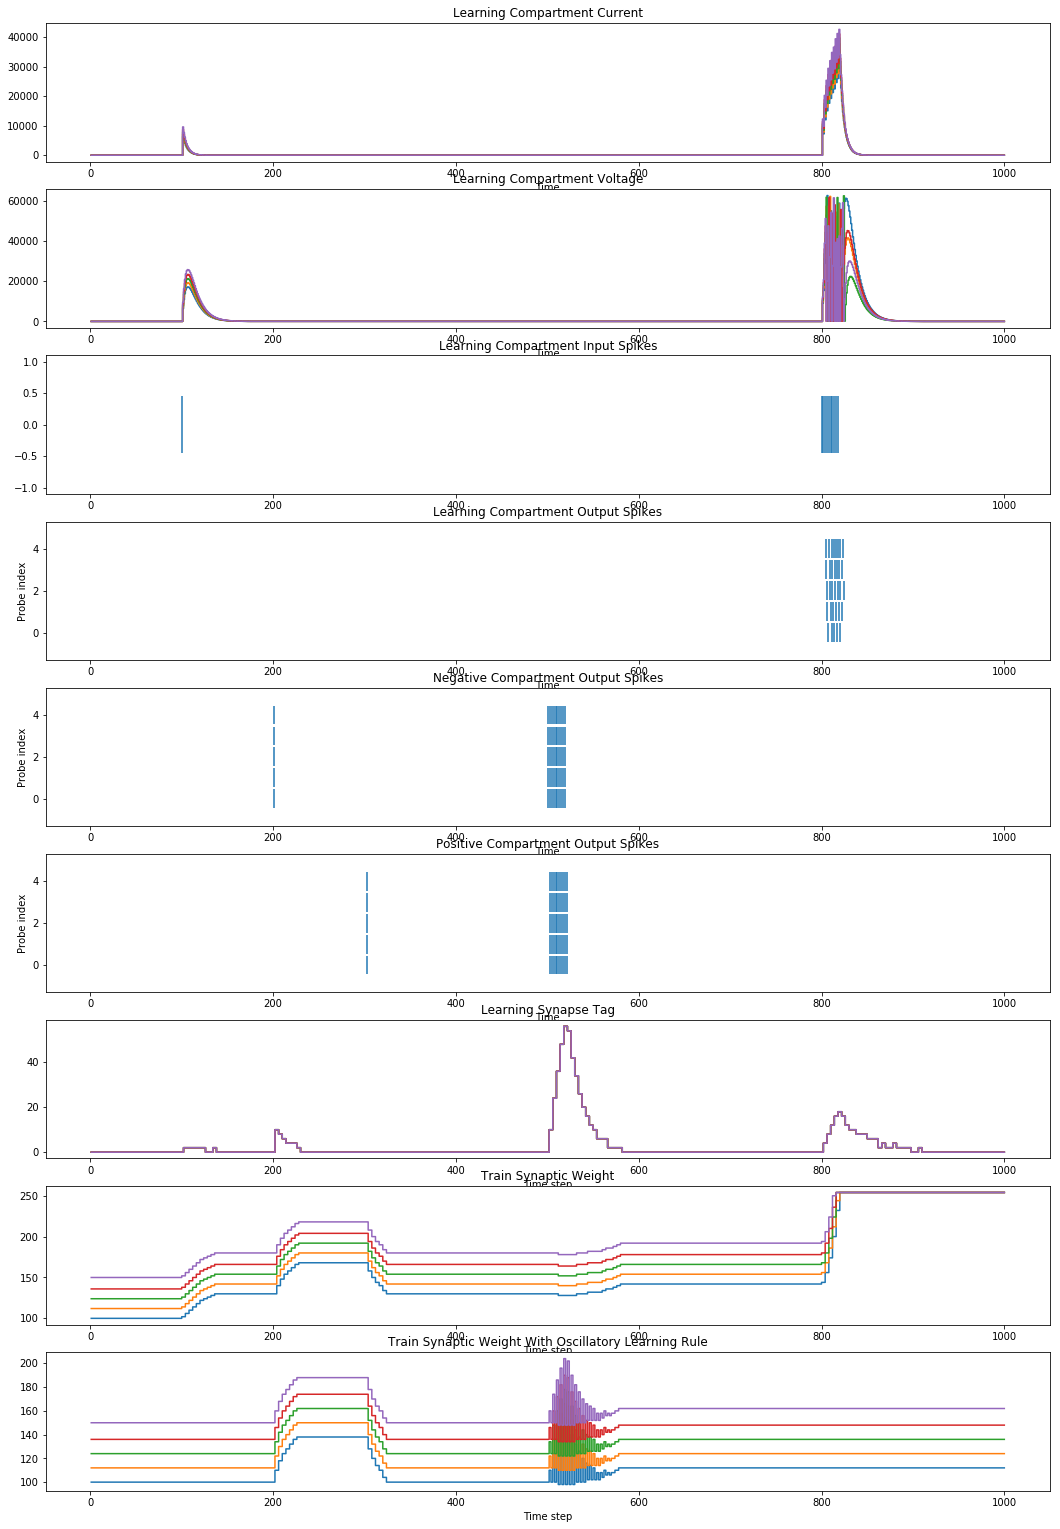

In [17]:
# Plot compartment current, voltage and spikes
numPlots = 9
plotNumber = 0
plt.figure(1, figsize=(18,numPlots*3))

plotNumber=plotNumber+1
ax = plt.subplot(numPlots, 1, plotNumber)
uProbe.plot()
plt.title('Learning Compartment Current')
limits = ax.get_xlim()

plotNumber=plotNumber+1
ax = plt.subplot(numPlots, 1, plotNumber)
vProbe.plot()
plt.title('Learning Compartment Voltage')

plotNumber=plotNumber+1
ax = plt.subplot(numPlots, 1, plotNumber)
plotRaster([spikeTimes])
plt.title('Learning Compartment Input Spikes')
ax.set_xlim(limits)

plotNumber=plotNumber+1
ax = plt.subplot(numPlots, 1, plotNumber)
sOutProbe.plot()
plt.title('Learning Compartment Output Spikes')
ax.set_xlim(limits)

plotNumber=plotNumber+1
ax = plt.subplot(numPlots, 1, plotNumber)
sNegProbe.plot()
plt.title('Negative Compartment Output Spikes')
ax.set_xlim(limits)

plotNumber=plotNumber+1
ax = plt.subplot(numPlots, 1, plotNumber)
sPosProbe.plot()
plt.title('Positive Compartment Output Spikes')
ax.set_xlim(limits)

plotNumber=plotNumber+1
ax = plt.subplot(numPlots, 1, plotNumber)
for ii in range(len(tLearnProbe)):
    tLearnProbe[ii][0].plot()
plt.title('Learning Synapse Tag')

plotNumber=plotNumber+1
ax = plt.subplot(numPlots, 1, plotNumber)
for ii in range(len(wLearnProbe)):
    wLearnProbe[ii][0].plot()
plt.title('Train Synaptic Weight')

plotNumber=plotNumber+1
ax = plt.subplot(numPlots, 1, plotNumber)
for ii in range(len(wLearnProbeOsc)):
    wLearnProbeOsc[ii][0].plot()
plt.title('Train Synaptic Weight With Oscillatory Learning Rule')


plt.show()

As a sanity check, we can look at the weight and tag of the negative and positive error compartments to make sure they are not affected.

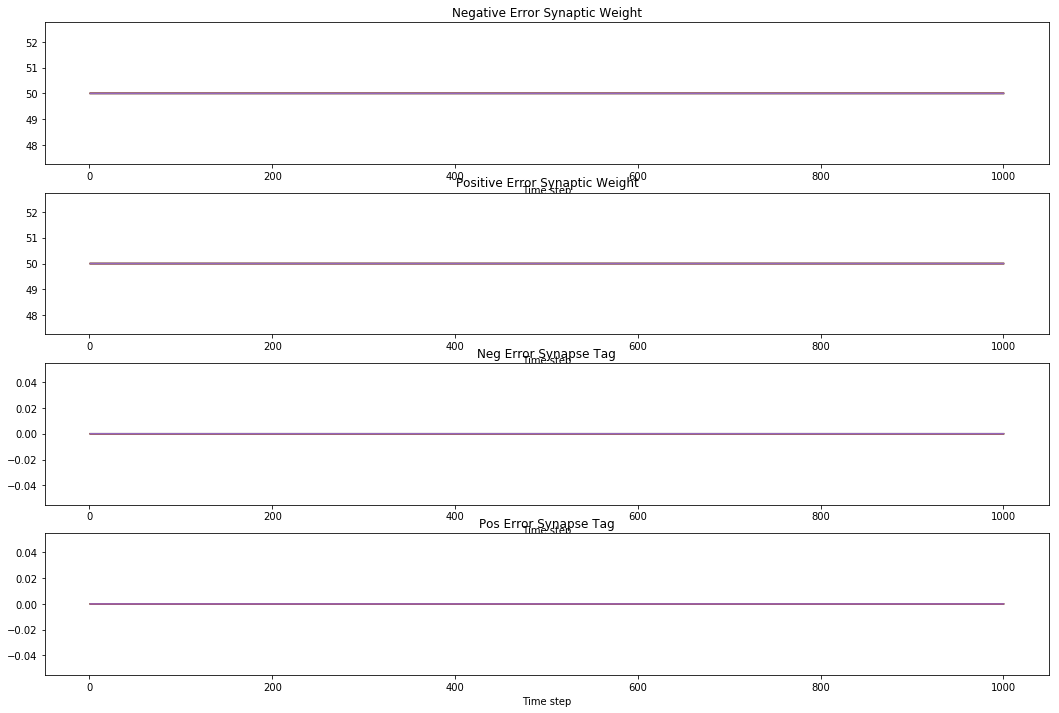

In [18]:
numPlots = 4
plotNumber = 0
plt.figure(1, figsize=(18,numPlots*3))

plotNumber=plotNumber+1
ax = plt.subplot(numPlots, 1, plotNumber)
for ii in range(len(wNegProbe)):
    wNegProbe[ii][0].plot()
plt.title('Negative Error Synaptic Weight')

plotNumber=plotNumber+1
ax = plt.subplot(numPlots, 1, plotNumber)
for ii in range(len(wPosProbe)):
    wPosProbe[ii][0].plot()
plt.title('Positive Error Synaptic Weight')

plotNumber=plotNumber+1
ax = plt.subplot(numPlots, 1, plotNumber)
for ii in range(len(tNegProbe)):
    tNegProbe[ii][0].plot()
plt.title('Neg Error Synapse Tag')

plotNumber=plotNumber+1
ax = plt.subplot(numPlots, 1, plotNumber)
for ii in range(len(tPosProbe)):
    tPosProbe[ii][0].plot()
plt.title('Pos Error Synapse Tag')

plt.show()